# Advanced Content Based Recommendation Net - Optimizations III



## A Practical Combination
In our scenario, a practical combination could include:

- Auxiliary Loss for Relevance Prediction: Adds multitask learning capability.
- Relevance-Based Weighting of Loss: Ensures relevant interactions are emphasized during training.
- Dynamic Attention Mechanisms: Enhances the Transformer block's ability to focus on relevant user-movie pairs.
- Relevance as an Input Feature: Provides explicit relevance information to the model. [Done by adding relevant movie idx as dynamic embedding layer]
- Precision-Targeted Recommendation: Adds an additional output for predicting relevance probabilities.

This combination balances architectural modifications, input enhancements, and loss optimizations. You can exclude others (e.g., contrastive - learning or collaborative filtering) for simplicity or focus on later experimentation. Let me know if you'd like to dive deeper into implementing this!

Rework the transformer block to optimally use it. Here are some options:


# Optimizing Transformer Usage for a Recommendation System

## Overview

The current architecture uses a Transformer to model interactions between `user_profile` and `movie_profile` as a sequence of length 2. While this works, the Transformer can be better utilized by providing it with richer inputs or restructured data. Below are several options to optimize Transformer usage.

---

## Option 1: Treat Features in the `user_profile` and `movie_profile` as Tokens

### Idea
Split the `user_profile` and `movie_profile` into meaningful sub-components and treat each sub-component as a "token" in a sequence.

### Example
- **`user_profile` (dim=791)**:
  - Demographic features (e.g., age, gender, location) → Embedding 1.
  - Interaction history (e.g., genres watched) → Embedding 2.
  - Numerical features (e.g., ratings given) → Embedding 3.

- **`movie_profile` (dim=1600)**:
  - Metadata (e.g., genre, director) → Embedding 4.
  - Textual embeddings (e.g., description/title embeddings) → Embedding 5.
  - Numerical features (e.g., release year) → Embedding 6.

**Input to Transformer:**
Each sub-component is projected into a dense vector (`transformer_d_model`):
```
Sequence: [user_embedding_1, user_embedding_2, ..., movie_embedding_1, movie_embedding_2, ...]
Shape: (B, seq_len, transformer_d_model)
```
Here, `seq_len = num_user_features + num_movie_features`.

### Benefits
- Allows the Transformer to attend over individual features.
- Captures richer relationships than a single dense embedding per profile.

---

## Option 2: Include Historical Interactions as a Sequence

### Idea
If historical interactions (e.g., movies watched, ratings) are available, treat them as a temporal sequence.

### Example
- **Historical interaction features** for a user:
  - Movie embeddings → Sequence of embeddings.
  - Interaction metadata (e.g., timestamp, rating) → Additional feature vectors.

**Input to Transformer:**
Combine the current user and movie profiles with historical interaction embeddings:
```
Sequence: [user_embedding, movie_embedding, interaction_1, interaction_2, ..., interaction_n]
Shape: (B, seq_len, transformer_d_model)
```

### Benefits
- Models temporal dependencies in user behavior.
- Captures how historical preferences evolve over time.

---

## Option 3: Use Multiple Views of the Same Data

### Idea
Construct a sequence with multiple views of the data:
1. **User Profile Embeddings:** Sub-components (demographics, preferences, etc.).
2. **Movie Profile Embeddings:** Sub-components (metadata, features, etc.).
3. **Contextual Features:** External context (e.g., time of day, device used).
4. **Auxiliary Features:** Embeddings for auxiliary labels or side information.

**Input to Transformer:**
Combine all views into a single sequence:
```
Sequence: [user_emb_1, user_emb_2, ..., movie_emb_1, movie_emb_2, ..., context_emb, aux_emb]
Shape: (B, seq_len, transformer_d_model)
```

### Benefits
- Fully utilizes the Transformer’s ability to model relationships across diverse feature sets.

---

## Option 4: Use Hierarchical Transformers

### Idea
Use separate Transformers for `user_profile` and `movie_profile`, followed by a global Transformer.

### Steps
1. **Local Transformer:** Process `user_profile` and `movie_profile` separately.
   - User features → Sequence of embeddings → Local Transformer.
   - Movie features → Sequence of embeddings → Local Transformer.

2. **Global Transformer:** Combine outputs of local Transformers into a single sequence and process.

**Example:**
```
Step 1: Local Transformers
- User features: [user_emb_1, user_emb_2, ..., user_emb_n] → (B, seq_len_user, transformer_d_model)
- Movie features: [movie_emb_1, movie_emb_2, ..., movie_emb_m] → (B, seq_len_movie, transformer_d_model)

Step 2: Global Transformer
- Sequence: [user_output, movie_output] → (B, 2, transformer_d_model)
```

### Benefits
- Reduces complexity by processing profiles separately.
- Leverages self-attention within and across profiles.

---

## Option 5: Add Positional or Segment Encodings

### Idea
Help the Transformer differentiate between `user_profile` and `movie_profile` embeddings by:
1. Adding **positional encodings** (e.g., index each embedding in the sequence).
2. Using **segment encodings** to mark embeddings as belonging to the user or movie profile.

**Example:**
```
Sequence: [user_emb_1, user_emb_2, ..., movie_emb_1, movie_emb_2]
Add segment IDs (0 for user, 1 for movie).
```

---

## Practical Recommendations

1. **Start with Sub-Component Segregation**:
   - Break `user_profile` and `movie_profile` into meaningful sub-components for a richer sequence.

2. **Extend with Historical Interactions**:
   - Add historical interactions if available for temporal modeling.

3. **Validate Performance**:
   - Test whether splitting profiles improves performance. Simpler collapsed embeddings may suffice if individual components aren't highly informative.

---

These optimizations ensure better utilization of the Transformer's strengths and provide richer inputs for our recommendation system.


ToDo: 

- add more data to UserProfile (votes average, number reviews...)
- realize Option 1 of Transformer Optimization
- realize Option 2 of Transformer Optimaztion (temporal information (movies rated, etc.))
- test a recommendation net with mapping only the attended output from the transformer to the fc layer

# Building the data pipeline
The following code builds the data pipeline so that we have usable data loaders.

In [3]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import pandas as pd
import torch
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from sentence_transformers import SentenceTransformer
import numpy as np
from codebase.v15.data import CustomMovieLensDataset, UserProfileCreator, MovieProfileCreator
import os
import torch.multiprocessing
from codebase.v15.utils import collate_fn

# Ensures proper multiprocessing behavior (problematic on google colab env)
torch.multiprocessing.set_start_method("spawn", force=True)

class Config:
    RATINGS_PATH = 'data/ml-10k-users/ratings.csv'
    MOVIES_ENRICHED_PATH = 'data/ml-10k-users/movies_enriched_tags.csv'
    USER_ENRICHED_PATH = 'data/ml-10k-users/users_enriched_tags.csv'
    USER_EMBEDDINGS_PATH = 'data/ml-10k-users/user_profiles.npy'
    MOVIE_EMBEDDINGS_PATH = 'data/ml-10k-users/movie_profiles.npy'
    BATCH_SIZE = 2048 * 3
    NUM_WORKERS = 8
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    os.environ["TOKENIZERS_PARALLELISM"] = "false"

def load_csv(path):
    """Load a CSV file and return a DataFrame."""
    return pd.read_csv(path)

def validate_ids(ratings, users_enriched, movies_enriched):
    """Filter and validate user and movie IDs."""
    valid_user_ids = set(ratings['userId']).intersection(set(users_enriched['userId']))
    valid_movie_ids = set(ratings['movieId']).intersection(set(movies_enriched['movieId']))
    print(f"Number of valid users: {len(valid_user_ids)}")
    print(f"Number of valid movies: {len(valid_movie_ids)}")
    return valid_user_ids, valid_movie_ids

def map_indices(ratings, valid_user_ids, valid_movie_ids):
    """Map userId and movieId to indices."""
    user_id_to_index = {user_id: idx for idx, user_id in enumerate(valid_user_ids)}
    movie_id_to_index = {movie_id: idx for idx, movie_id in enumerate(valid_movie_ids)}
    ratings = ratings[
        (ratings['userId'].isin(valid_user_ids)) & (ratings['movieId'].isin(valid_movie_ids))
    ]
    ratings['userIndex'] = ratings['userId'].map(user_id_to_index)
    ratings['movieIndex'] = ratings['movieId'].map(movie_id_to_index)
    return ratings

def temporal_split(ratings):
    """Split ratings data into train, validation, and test sets temporally."""
    ratings = ratings.sort_values('timestamp')
    train_end = int(0.7 * len(ratings))
    val_end = int(0.85 * len(ratings))
    return ratings.iloc[:train_end], ratings.iloc[train_end:val_end], ratings.iloc[val_end:]

class ProfileLoader:
    @staticmethod
    def load_or_create_profiles(creator, df, path, message):
        """Load profiles from disk or create and save them."""
        if os.path.exists(path):
            print(f"Loading {message} from disk...")
            profiles = np.load(path)
            print(f"{message} loaded.")
        else:
            print(f"Creating {message}...")
            profiles = creator.create_profiles(df)
            np.save(path, profiles)
            print(f"{message} saved to disk.")
        return profiles

def prepare_data(config):
    # Load data
    ratings = load_csv(config.RATINGS_PATH)
    movies_enriched = load_csv(config.MOVIES_ENRICHED_PATH)
    users_enriched = load_csv(config.USER_ENRICHED_PATH)

    # Validate IDs
    valid_user_ids, valid_movie_ids = validate_ids(ratings, users_enriched, movies_enriched)

    # Map indices
    ratings = map_indices(ratings, valid_user_ids, valid_movie_ids)

    # Create genre vocab
    genre_vocab = sorted(
        set(
            [
                genre.strip()
                for genre in ','.join(users_enriched['favorite_genres'].dropna()).split(',')
            ]
            + [
                genre.strip()
                for genre in '|'.join(movies_enriched['genres'].dropna()).split('|')
            ]
        )
    )

    # Temporal split
    train_data, val_data, test_data = temporal_split(ratings)

    return ratings, train_data, val_data, test_data, genre_vocab, valid_user_ids, valid_movie_ids


def prepare_profiles(config, genre_vocab, users_enriched, movies_enriched, valid_user_ids, valid_movie_ids):
    text_model_tags = SentenceTransformer("all-MiniLM-L6-v2").to(config.DEVICE)  # 384
    text_model_plots = SentenceTransformer("all-MiniLM-L12-v2").to(config.DEVICE)  # 384

    user_creator = UserProfileCreator(text_model=text_model_tags, genre_vocab=genre_vocab)
    movie_creator = MovieProfileCreator(
        text_model_tags=text_model_tags, text_model_plots=text_model_plots, genre_vocab=genre_vocab
    )

    filtered_users_df = users_enriched[users_enriched['userId'].isin(valid_user_ids)].reset_index(drop=True)
    user_profiles = ProfileLoader.load_or_create_profiles(
        user_creator, filtered_users_df, config.USER_EMBEDDINGS_PATH, "user profiles"
    )

    filtered_movies_df = movies_enriched[movies_enriched['movieId'].isin(valid_movie_ids)].reset_index(drop=True)
    movie_profiles = ProfileLoader.load_or_create_profiles(
        movie_creator, filtered_movies_df, config.MOVIE_EMBEDDINGS_PATH, "movie profiles"
    )

    return user_profiles, movie_profiles

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
def prepare_data_pipleline():
    config = Config()

    # Prepare data
    ratings, train_data, val_data, test_data, genre_vocab, valid_user_ids, valid_movie_ids = prepare_data(config)

    # Prepare profiles
    user_profiles, movie_profiles = prepare_profiles(
        config, genre_vocab, load_csv(config.USER_ENRICHED_PATH), load_csv(config.MOVIES_ENRICHED_PATH),
        valid_user_ids, valid_movie_ids
    )

    # Dataset preparation
    user_token_dims = {
        "age": 1, "num_reviews": 1, "avg_rating": 1,
        "genres": len(genre_vocab), "spending_category": 3, "gender": 2, "tags": 384
    }
    movie_token_dims = {
        "budget": 1, "popularity": 1, "runtime": 1, "vote_average": 1, "vote_count": 1,
        "overview": 384, "genres": len(genre_vocab), "tags": 384
    }

    train_dataset = CustomMovieLensDataset(train_data, user_profiles, movie_profiles, genre_vocab, user_token_dims, movie_token_dims)
    val_dataset = CustomMovieLensDataset(val_data, user_profiles, movie_profiles, genre_vocab, user_token_dims, movie_token_dims)
    test_dataset = CustomMovieLensDataset(test_data, user_profiles, movie_profiles, genre_vocab, user_token_dims, movie_token_dims)

    train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True, num_workers=config.NUM_WORKERS, collate_fn=collate_fn)
    val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS, collate_fn=collate_fn)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, num_workers=config.NUM_WORKERS, collate_fn=collate_fn)

    print("Data preparation complete!")
    print(f"Train samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Test samples: {len(test_dataset)}")

    return (
            train_loader, val_loader, test_loader, 
            ratings, train_data, val_data, test_data, 
            genre_vocab, user_profiles, movie_profiles, 
            valid_movie_ids, valid_user_ids
        )

In [6]:
import time

def measure_dataloader_time(data_loader, num_batches=10):
    """
    Measure the time it takes to iterate through the DataLoader.

    Args:
        data_loader (DataLoader): The PyTorch DataLoader to measure.
        num_batches (int): Number of batches to process for timing (default: 10).

    Returns:
        float: Average time per batch (in seconds).
    """
    total_time = 0
    for i, batch in enumerate(data_loader):
        if i >= num_batches:
            break
        start_time = time.time()
        
        # Simulate processing batch (no actual training, just loading)
        user_tokens, movie_tokens, rating, _, rated_movies = batch

        # Simulate transfer to device (optional, if using GPU)
        # Uncomment if needed:
        # user_tokens = {k: v.to(device) for k, v in user_tokens.items()}
        # movie_tokens = {k: v.to(device) for k, v in movie_tokens.items()}
        # rating = rating.to(device)
        # rated_movies = rated_movies.to(device)

        end_time = time.time()
        batch_time = end_time - start_time
        total_time += batch_time
        print(f"Batch {i + 1}/{num_batches} loaded in {batch_time:.4f} seconds")

    avg_time_per_batch = total_time / min(len(data_loader), num_batches)
    print(f"Average time per batch: {avg_time_per_batch:.4f} seconds")
    return avg_time_per_batch

# Example usage
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Number of batches: ", len(train_loader))

measure_dataloader_time(train_loader, num_batches=714)


NameError: name 'train_loader' is not defined

In [22]:
# let's test the LazyJaccardMovieLensDataset based DataLoader
def test_jaccard_dataset(dataset):
    overlap_count = 0
    total_samples = len(dataset)

    for _, _, _, jaccard_label, _ in dataset:
        if jaccard_label > 0:
            overlap_count += 1

    overlap_percentage = (overlap_count / total_samples) * 100
    print(f"Total Samples: {total_samples}")
    print(f"Samples with Genre Overlap (Jaccard > 0): {overlap_count}")
    print(f"Genre Overlap Percentage: {overlap_percentage:.2f}%")

# Run the test
test_jaccard_dataset(train_dataset)

Total Samples: 1105126
Samples with Genre Overlap (Jaccard > 0): 226251
Genre Overlap Percentage: 20.47%


## Let's inspect the data and the pipeline we just created:

In [6]:
def test_genre_label_alignment(movies_enriched, movie_profiles, genre_vocab, genre_start_idx):
    """
    Test if genre labels align with the ground truth in the movies_enriched DataFrame.

    Args:
        movies_enriched (pd.DataFrame): DataFrame with original movie genres.
        movie_profiles (np.ndarray): Precomputed movie profiles containing multi-hot encoded genres.
        genre_vocab (list): List of all possible genres in sorted order.
        genre_start_idx (int): Index in movie_profiles where genre encoding starts.

    Returns:
        None. Prints results of the test.
    """
    # Extract the multi-hot encoded genres from movie_profiles
    num_movies = len(movie_profiles)
    
    genre_profiles = movie_profiles[:, genre_start_idx:genre_start_idx + len(genre_vocab)]
    
    mismatch_count = 0

    # Iterate through movies and compare the genres
    for idx in range(num_movies):
        # Original genres as a set
        original_genres = set(
            [genre.strip() for genre in movies_enriched.iloc[idx]['genres'].split('|') if genre.strip()]
        )

        # Multi-hot decoded genres
        decoded_genres = {genre_vocab[i] for i, value in enumerate(genre_profiles[idx]) if value > 0}
        
        # Check if they match
        if original_genres != decoded_genres:
            mismatch_count += 1
            print(f"Mismatch for movie at index {idx}:")
            print(f"Original genres: {original_genres}")
            print(f"Decoded genres: {decoded_genres}")
            print("---")
    
    # Summary
    if mismatch_count == 0:
        print("All genre labels align perfectly with the ground truth!")
    else:
        print(f"Total mismatches: {mismatch_count}/{num_movies}")

# Example Call
genre_start_idx = (
    movie_tokens.shape[1] - len(genre_vocab) - 384  # Adjust to account for tag embedding size (384)
)

test_genre_label_alignment(
    movies_enriched[movies_enriched['movieId'].isin(valid_movie_ids)], movie_tokens, genre_vocab, genre_start_idx
)

All genre labels align perfectly with the ground truth!


### Test the data loader

In [7]:
# Example: Testing the ContentFeatureMovieLensDataset
def test_dataset(dataset, num_samples=10):
    """
    Test the ContentFeatureMovieLensDataset to verify it repeats user_profiles for corresponding movie_items.

    Args:
        dataset (Dataset): The dataset to test.
        num_samples (int): Number of samples to print for testing.
    """
    print("Testing the dataset...\n")
    print("Sample outputs (user_profile, movie_profile, rating, genre_similarity, relevance):\n")

    for i in range(min(num_samples, len(dataset))):
        user_profile, movie_profile, rating, genre_overlap, relevant_movies = dataset[i]

        # Print details for the sample
        print(f"Sample {i + 1}:")
        print(f"  User Profile (first 20 values): {user_profile.numpy()[:20]}...")
        print(f"  Movie Profile (first 20 values): {movie_profile.numpy()[:20]}...")
        print(f"  Rating: {rating.item()}")
        print(f"  Genre Similarity: {genre_overlap:.4f}")
        print(f"  Relevant Movies: {relevant_movies.numpy()[:20]}")
        print("-" * 50)

# Create a test dataset instance
# Assuming you already have these variables from your preprocessing:
# - ratings (DataFrame with 'userIndex', 'movieIndex', 'rating')
# - user_profiles (numpy array)
# - movie_profiles (numpy array)

# Example instantiation of the dataset
test_dataset_instance = JaccardRelevanceMovieLensDataset(
    ratings, user_tokens, movie_tokens, genre_vocab, user_rated_movies
)

# Test the dataset
test_dataset(test_dataset_instance, num_samples=20)

Testing the dataset...

Sample outputs (user_profile, movie_profile, rating, genre_similarity, relevance):

Sample 1:
  User Profile (first 20 values): [0.40425533 0.34545454 0.68157893 0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]...
  Movie Profile (first 20 values): [ 0.          0.01981227  0.11332503  0.54        0.01017125 -0.13053547
  0.02834057 -0.0311903  -0.00929061 -0.10225368  0.05615535  0.07939175
  0.02069186  0.00746278  0.0141927   0.0679702  -0.01183404 -0.01863809
 -0.09235159  0.00317484]...
  Rating: 4.0
  Genre Similarity: 0.0000
  Relevant Movies: [  5  10  24  85 109 159 222 291 313 351 352 356 372 375 451 469 521 533
 579 581]
--------------------------------------------------
Sample 2:
  User Profile (first 20 values): [0.40425533 0.34545454 0.68157893 0.         0.         0.
 0.         0.         1.         0.         0.         0.
 0.  

### Check for NaN:

In [19]:
import numpy as np

def analyze_nan_in_movie_profiles(movie_profiles, column_structure):
    """
    Analyze `movie_profiles` for NaN values and identify affected columns and profiles.
    Args:
        movie_profiles (np.ndarray): Array of movie profiles.
        column_structure (dict): Dictionary defining column ranges for each feature type.
            Example: {
                "numerical_features": (0, 5),  # Start and end index for numerical features
                "overview_embedding": (5, 773),
                "scaled_genres": (773, 791)
            }
    Returns:
        dict: Analysis results, including affected column groups and profile count.
    """
    nan_counts = {}
    total_nan_profiles = 0

    # Analyze each feature group based on column structure
    for feature, (start, end) in column_structure.items():
        feature_data = movie_profiles[:, start:end]
        nan_mask = np.isnan(feature_data)
        nan_count = np.sum(nan_mask)
        nan_profiles = np.sum(np.any(nan_mask, axis=1))  # Profiles with at least one NaN in this range

        nan_counts[feature] = {
            "total_nans": nan_count,
            "affected_profiles": nan_profiles
        }
        total_nan_profiles += nan_profiles

    # Ensure total_nan_profiles isn't double-counted
    total_nan_profiles = np.sum(np.any(np.isnan(movie_profiles), axis=1))

    return {
        "nan_counts": nan_counts,
        "total_nan_profiles": total_nan_profiles
    }

# Define the column structure
column_structure = {
    "numerical_features": (0, 5),
    "overview_embedding": (5, 773),
    "scaled_genres": (773, 791)
}

# Analyze NaN values in movie_profiles
nan_analysis = analyze_nan_in_movie_profiles(movie_tokens, column_structure)

# Display results
print("NaN Analysis Results:")
for feature, stats in nan_analysis["nan_counts"].items():
    print(f"{feature}: Total NaNs = {stats['total_nans']}, Affected Profiles = {stats['affected_profiles']}")

print(f"Total Profiles with NaN Values: {nan_analysis['total_nan_profiles']}")


NaN Analysis Results:
numerical_features: Total NaNs = 0, Affected Profiles = 0
overview_embedding: Total NaNs = 0, Affected Profiles = 0
scaled_genres: Total NaNs = 0, Affected Profiles = 0
Total Profiles with NaN Values: 0


In [20]:
# Validate user_profiles
num_unique_users = ratings['userId'].nunique()
assert user_tokens.shape[0] == num_unique_users, (
    f"Mismatch: user_profiles has {user_tokens.shape[0]} rows, "
    f"but ratings.csv has {num_unique_users} unique userId values."
)
print("Validation passed: user_profiles matches the number of unique users in ratings.csv.")

# Validate movie_profiles
num_unique_movies = ratings['movieId'].nunique()
assert movie_tokens.shape[0] == num_unique_movies, (
    f"Mismatch: movie_profiles has {movie_tokens.shape[0]} rows, "
    f"but ratings.csv has {num_unique_movies} unique movieId values."
)
print("Validation passed: movie_profiles matches the number of unique movies in ratings.csv.")

# Fetch a single batch of data from the train loader
sample_batch = next(iter(train_loader))

# Unpack the batch: user profiles, movie profiles, and ratings
user_tokens, movie_tokens, ratings, genre_overlap = sample_batch

# Convert tensors to numpy arrays for inspection
user_tokens = user_tokens.numpy()
movie_tokens = movie_tokens.numpy()
ratings = ratings.numpy()

# Verify alignment
print("Verifying alignment of user profiles, movie profiles, and ratings:")
for i in range(5):  # Check the first 5 rows
    print(f"User Profile {i + 1}: {user_tokens[i][:5]}...")  # Show first few values for brevity
    print(f"Movie Profile {i + 1}: {movie_tokens[i][:5]}...")  # Show first few values for brevity
    print(f"Rating {i + 1}: {ratings[i]}")
    print("-" * 50)

print("Max value in user_profiles:", np.max(user_tokens))
print("Min value in user_profiles:", np.min(user_tokens))
print("Max value in movie_profiles:", np.max(movie_tokens))
print("Min value in movie_profiles:", np.min(movie_tokens))

print()

assert not np.any(np.isnan(user_tokens)), "NaN values found in user_profiles!"
assert not np.any(np.isinf(user_tokens)), "Infinite values found in user_profiles!"
assert not np.any(np.isnan(movie_tokens)), "NaN values found in movie_profiles!"
assert not np.any(np.isinf(movie_tokens)), "Infinite values found in movie_profiles!"

def check_nan_in_dataloader(data_loader):
    """
    Check for NaN values in user_profiles, movie_profiles, and ratings from a DataLoader.
    Args:
        data_loader (DataLoader): The PyTorch DataLoader to check.
    Returns:
        dict: Contains the count of batches with NaN values and examples if found.
    """
    nan_details = {
        "user_profiles": 0,
        "movie_profiles": 0,
        "ratings": 0,
        "example_batch": None
    }

    for batch_idx, (user_profiles, movie_profiles, ratings, _, _) in enumerate(data_loader):
        # Check for NaN in user_profiles
        if torch.isnan(user_profiles).any():
            nan_details["user_profiles"] += 1

        # Check for NaN in movie_profiles
        if torch.isnan(movie_profiles).any():
            nan_details["movie_profiles"] += 1

        # Check for NaN in ratings
        if torch.isnan(ratings).any():
            nan_details["ratings"] += 1

        # If any NaN values are found, store an example batch
        if (nan_details["user_profiles"] > 0 or 
            nan_details["movie_profiles"] > 0 or 
            nan_details["ratings"] > 0) and nan_details["example_batch"] is None:
            nan_details["example_batch"] = {
                "batch_idx": batch_idx,
                "user_profiles": user_profiles,
                "movie_profiles": movie_profiles,
                "ratings": ratings
            }

    return nan_details

nan_check_result = check_nan_in_dataloader(train_loader)
print()

# Display the results
print("NaN Check Results:")
print(f"NaN in user_profiles: {nan_check_result['user_profiles']} batches")
print(f"NaN in movie_profiles: {nan_check_result['movie_profiles']} batches")
print(f"NaN in ratings: {nan_check_result['ratings']} batches")

if nan_check_result["example_batch"] is not None:
    print("\nExample Batch with NaN Values:")
    example_batch = nan_check_result["example_batch"]
    print(f"Batch Index: {example_batch['batch_idx']}")
    print(f"User Profiles:\n{example_batch['user_profiles']}")
    print(f"Movie Profiles:\n{example_batch['movie_profiles']}")
    print(f"Ratings:\n{example_batch['ratings']}")
else:
    print("No NaN values found in the data loader!")

Validation passed: user_profiles matches the number of unique users in ratings.csv.
Validation passed: movie_profiles matches the number of unique movies in ratings.csv.
Verifying alignment of user profiles, movie profiles, and ratings:
User Profile 1: [0.31914893 0.         0.         0.         0.        ]...
Movie Profile 1: [0.00869565 0.01290053 0.1359354  0.58       0.00095441]...
Rating 1: 4.0
--------------------------------------------------
User Profile 2: [0. 0. 1. 1. 0.]...
Movie Profile 2: [0.00392391 0.01963408 0.13189772 0.66       0.00373582]...
Rating 2: 3.5
--------------------------------------------------
User Profile 3: [0.31914893 0.         0.         0.         0.        ]...
Movie Profile 3: [0.         0.01041352 0.1076716  0.65       0.00755345]...
Rating 3: 4.0
--------------------------------------------------
User Profile 4: [0.19148937 0.         0.         0.         0.        ]...
Movie Profile 4: [0.0000000e+00 1.9673943e-03 1.5208614e-01 6.9000000e-01

In [8]:
import numpy as np

def find_max_value_of_user_profile(profiles, start_index, end_index):
    """
    Find the profile index with the maximum value over all embedding dimensions.
    Args:
        profiles (np.ndarray): Profiles array (user or movie profiles).
        start_index (int): Starting index for embedding dimensions (e.g., 1 or 4).
    Returns:
        dict: Information about the profile with the maximum value.
    """
    # Extract embedding dimensions
    embeddings = profiles[:, start_index:end_index]

    # Find the maximum value and its location
    max_value = np.max(embeddings)
    profile_index = np.argmax(np.max(embeddings, axis=1))

    # Return details
    return {
        "profile_index": profile_index,
        "max_value": max_value,
        "profile_values": profiles[profile_index][:10],
    }

def find_users_with_multiple_genres(user_profiles, threshold=1):
    """
    Find user profiles with more than one genre assigned.
    Args:
        user_profiles (np.ndarray): User profiles encoded with the structure:
            - 1st column: age
            - Next 18 columns: multi-hot encoded genres
            - Last 2 columns: sex (one-hot encoded).
    Returns:
        dict: {
            "count": Number of matching user profiles,
            "example_profile": One example profile with multiple genres.
        }
    """
    # Extract the genre columns (2nd to 19th columns, 0-indexed)
    genre_columns = user_profiles[:, 3:20]
    genre_columns = (genre_columns > 0).astype(int)

    # Find profiles with more than one genre assigned
    multiple_genres_mask = np.sum(genre_columns, axis=1) > threshold
    matching_profiles = user_profiles[multiple_genres_mask]

    # Return the count and one example (if available)
    return {
        "count": len(matching_profiles),
        "example_profile": matching_profiles[0][:10] if len(matching_profiles) > 0 else None
    }


# Find the user with the maximum age
print(f"Max value profile: {find_max_value_of_user_profile(user_tokens, start_index=1, end_index=20)}")
print()
print(f"Number of Users in user profiles: {user_tokens.shape[0]}")
print(f"Users with multiple genres: {find_users_with_multiple_genres(user_tokens, 2)}")

Max value profile: {'profile_index': 0, 'max_value': 1.0, 'profile_values': array([0.29787234, 0.30909091, 0.60263158, 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])}

Number of Users in user profiles: 10000
Users with multiple genres: {'count': 1896, 'example_profile': array([0.14893617, 0.12727273, 0.6       , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])}


Let's visualize data from the created loaders.

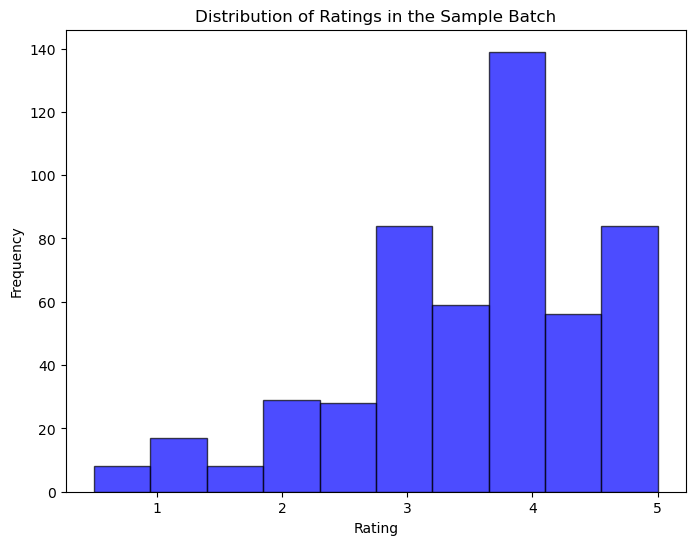

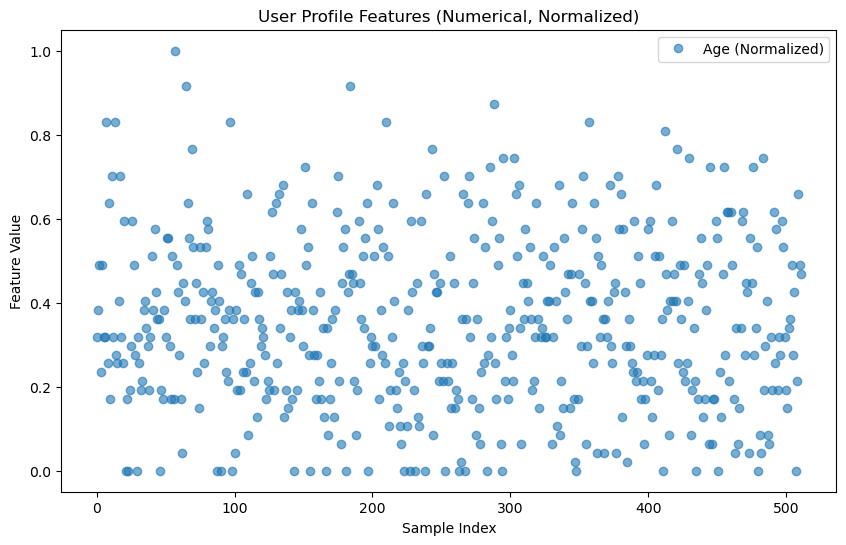

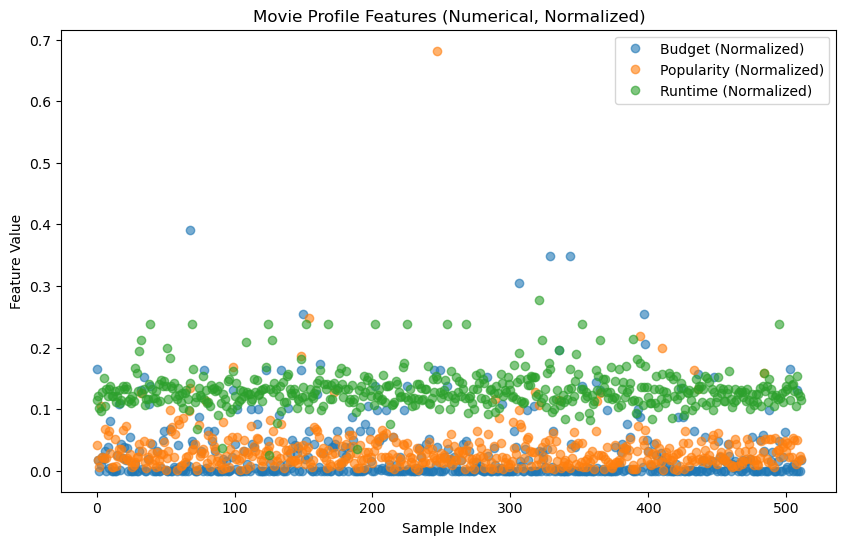

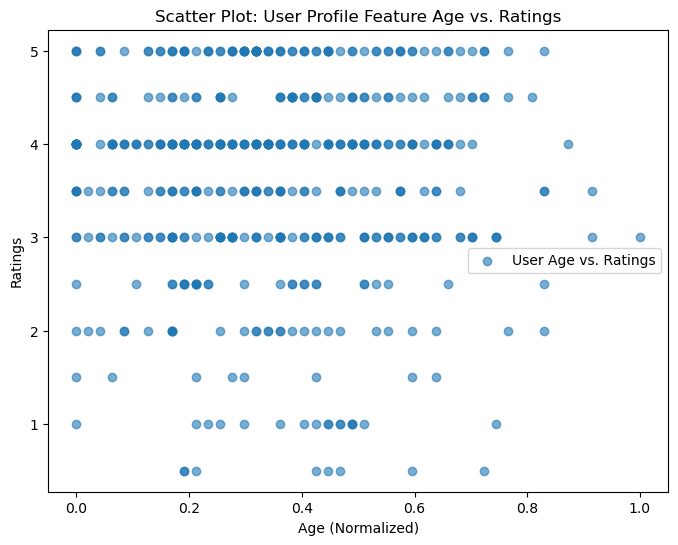

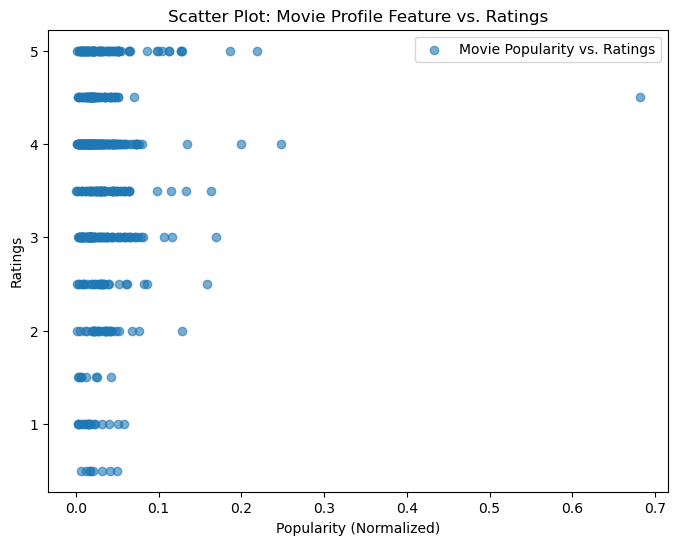

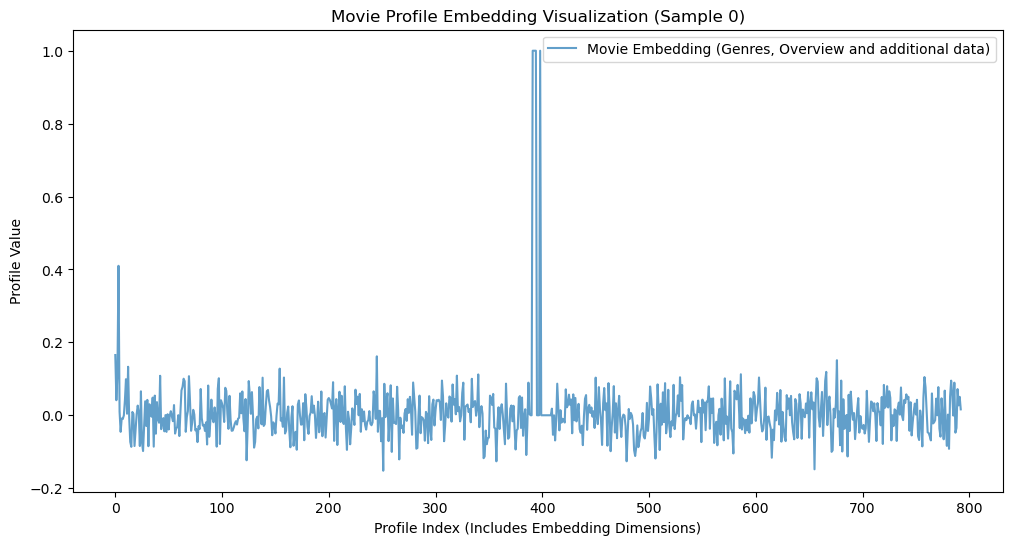

User Profiles data:


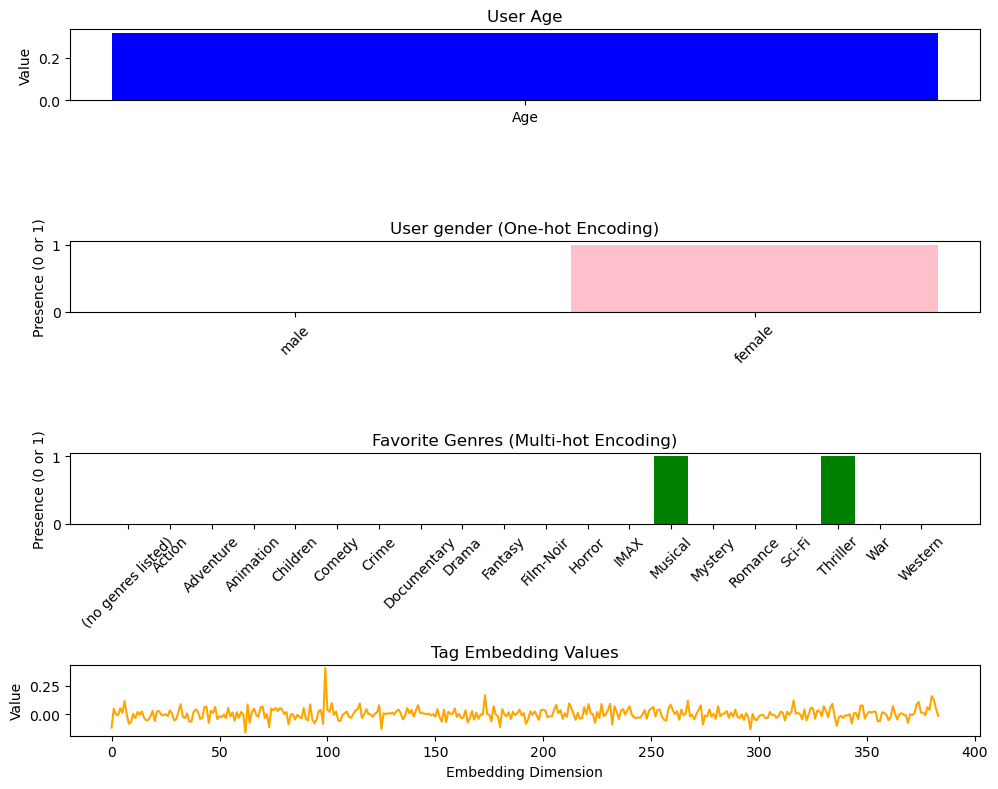

In [9]:
import matplotlib.pyplot as plt

# Helper function to fetch a batch of data from the DataLoader
def get_sample_batch(loader):
    """Fetch a single batch of data from a DataLoader."""
    for batch in loader:
        return batch  # Return the first batch

import matplotlib.pyplot as plt
import numpy as np

def plot_user_profile(user_profiles, genre_vocab, tag_embedding_dim):
    """
    Plot a visualization of a user profile.
    
    Args:
        user_profiles (np.ndarray): Array of user profiles.
        genre_vocab (list): List of all possible genres.
        tag_embedding_dim (int): Dimension of tag embeddings.
    """
    # Select the first user profile for demonstration
    user_profile = user_profiles[0]
    
    # Profile breakdown
    age = user_profile[0]
    genres = user_profile[3:3+len(genre_vocab)]
    tags = user_profile[3+len(genre_vocab)+3+2:3+len(genre_vocab)+3+2+tag_embedding_dim]
    gender = user_profile[3+len(genre_vocab)+3:3+len(genre_vocab)+3+2]
    
    # Plot
    _, axes = plt.subplots(4, 1, figsize=(10, 8))
    
    # Age (Numerical Feature)
    axes[0].bar(["Age"], [age], color='blue')
    axes[0].set_title("User Age")
    axes[0].set_ylabel("Value")
    
    # Favorite Genres (Multi-hot)
    axes[1].bar(['male', 'female'], gender, color='pink')
    axes[1].set_title("User gender (One-hot Encoding)")
    axes[1].set_ylabel("Presence (0 or 1)")
    axes[1].tick_params(axis='x', rotation=45)

    # Favorite Genres (Multi-hot)
    axes[2].bar(genre_vocab, genres, color='green')
    axes[2].set_title("Favorite Genres (Multi-hot Encoding)")
    axes[2].set_ylabel("Presence (0 or 1)")
    axes[2].tick_params(axis='x', rotation=45)
    
    # Tags (Embeddings)
    axes[3].plot(tags, color='orange')
    axes[3].set_title("Tag Embedding Values")
    axes[3].set_ylabel("Value")
    axes[3].set_xlabel("Embedding Dimension")
    
    plt.tight_layout()
    plt.show()

# Extract a sample batch from the train loader
sample_batch = get_sample_batch(train_loader)

# Unpack the batch: user profiles, movie profiles, and ratings
user_tokens, movie_tokens, ratings, genre_overlap, relevance = sample_batch

# Convert tensors to numpy for visualization
user_tokens = user_tokens.numpy()
movie_tokens = movie_tokens.numpy()
ratings = ratings.numpy()

# 1. Visualize the distribution of ratings
plt.figure(figsize=(8, 6))
plt.hist(ratings, bins=10, color='blue', alpha=0.7, edgecolor='black')
plt.title("Distribution of Ratings in the Sample Batch")
plt.xlabel("Rating")
plt.ylabel("Frequency")
plt.show()

# 2. Visualize numerical features from user profiles (the only numerical feature: age)
plt.figure(figsize=(10, 6))
plt.plot(user_tokens[:, 0], 'o', label='Age (Normalized)', alpha=0.6)
plt.title("User Profile Features (Numerical, Normalized)")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value")
plt.legend()
plt.show()

# 3. Visualize numerical features from movie profiles (first 3 numerical features)
plt.figure(figsize=(10, 6))
plt.plot(movie_tokens[:, 0], 'o', label='Budget (Normalized)', alpha=0.6)
plt.plot(movie_tokens[:, 1], 'o', label='Popularity (Normalized)', alpha=0.6)
plt.plot(movie_tokens[:, 2], 'o', label='Runtime (Normalized)', alpha=0.6)
plt.title("Movie Profile Features (Numerical, Normalized)")
plt.xlabel("Sample Index")
plt.ylabel("Feature Value")
plt.legend()
plt.show()

# 4. Visualize the relationship between a user profile feature and ratings
plt.figure(figsize=(8, 6))
plt.scatter(user_tokens[:, 0], ratings, alpha=0.6, label="User Age vs. Ratings")
plt.title("Scatter Plot: User Profile Feature Age vs. Ratings")
plt.xlabel("Age (Normalized)")
plt.ylabel("Ratings")
plt.legend()
plt.show()

# 5. Visualize the relationship between a movie profile feature and ratings
plt.figure(figsize=(8, 6))
plt.scatter(movie_tokens[:, 1], ratings, alpha=0.6, label="Movie Popularity vs. Ratings")
plt.title("Scatter Plot: Movie Profile Feature vs. Ratings")
plt.xlabel("Popularity (Normalized)")
plt.ylabel("Ratings")
plt.legend()
plt.show()

# Inspect embeddings for a random movie profile
plt.figure(figsize=(12, 6))
plt.plot(movie_tokens[0, 0:], label="Movie Embedding (Genres, Overview and additional data)", alpha=0.7)
plt.title("Movie Profile Embedding Visualization (Sample 0)")
plt.xlabel("Profile Index (Includes Embedding Dimensions)")
plt.ylabel("Profile Value")
plt.legend()
plt.show()

print("User Profiles data:")
plot_user_profile(user_tokens, genre_vocab, tag_embedding_dim=384)

You may wonder why the Profile Index (Includes Embedding Dimensions) are larger than the embedding dimension of a single SBERT encoded text. This is because the final embedding vector contains multiple embeddings, the numerical embeddings as textual embeddings too.

**User Profile**
Numerical Features:

***Embeddings***
Tags embedding = 384 dimensions

Age, genres, sex = 1(age) + number(genres) + 2(sex) dimensions + 384(tags_user).

Total Dimensions:
1(Numerical) + 18(Genres one-hot) + 2(Categorial) = 21 + 384.


**Movie Profile**
Numerical Features:

Budget, popularity, runtime, vote_average, vote_count = 5 dimensions.

Genres = 18

***Embeddings***:
Overview embedding = 384 dimensions.
Tags embedding = 384 dimensions.

5 (Numerical) + 18 (Genres) + 384 (Overview) + 384 (tags_by_users) = 407 + 384.

# The recommendation net and training code

The **code** for the recommendation net can be found in **codebase/models.py** or **codebase/models_advanced.py**.

The training code:

In [5]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter
import sys
import torch
from torch.optim import AdamW
from torch.optim.lr_scheduler import LambdaLR
from torch.amp import autocast, GradScaler
import torch.profiler as profiler

def multitask_loss(criterion, predictions, rating, beta=0.5):
    """
    Multitask loss combining regression loss and vectorized BPR ranking loss.
    """
    # 1) Main regression loss (e.g., MSE for rating)
    loss = criterion(predictions, rating)

    # 2) Vectorized BPR ranking loss
    if beta > 0:
        diff_ratings = rating.unsqueeze(1) - rating.unsqueeze(0)  # [batch_size, batch_size]
        diff_predictions = predictions.unsqueeze(1) - predictions.unsqueeze(0)  # [batch_size, batch_size]
        valid_pairs = diff_ratings > 0  # Only keep pairs where rating[i] > rating[j]
        if valid_pairs.any():
            bpr_loss = -F.logsigmoid(diff_predictions[valid_pairs]).mean()
        else:
            bpr_loss = torch.tensor(0.0, device=predictions.device)
        loss += beta * bpr_loss

    return loss.mean()

def train(
    model, optimizer, scheduler, criterion, train_loader, val_loader,
    num_epochs=10, patience=3, model_path='best_model.pth', log_dir=None, beta=0.5
):
    """
    Train the RecommendationNet model with the updated user_tokens and movie_tokens.

    Args:
        model: RecommendationNet instance.
        optimizer: Optimizer for training.
        scheduler: Learning rate scheduler.
        criterion: Loss function.
        train_loader: DataLoader for training data.
        val_loader: DataLoader for validation data.
        num_epochs: Number of epochs to train.
        patience: Early stopping patience.
        model_path: Path to save the best model.
        log_dir: Directory for TensorBoard logs.
        beta: Weight for the BPR loss.
    """
    # TensorBoard writer
    writer = SummaryWriter(log_dir=log_dir) if log_dir else None
    scaler = GradScaler()  # Mixed-precision training

    # Early stopping variables
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    
    for epoch in range(num_epochs):
        model.train()
        total_loss = 0

        # Training loop
        for batch in train_loader:
            user_tokens, movie_tokens, rating, _ = batch

            # Move data to device
            user_tokens = {k: v.to(device) for k, v in user_tokens.items()}
            movie_tokens = {k: v.to(device) for k, v in movie_tokens.items()}
            rating = rating.to(device).view(-1, 1)

            optimizer.zero_grad()

            # Forward pass with mixed precision
            with autocast(device.type):
                predictions, _ = model(user_tokens, movie_tokens)
                loss = multitask_loss(criterion, predictions, rating, beta=beta)

            # Backward pass and optimization with GradScaler
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            # Step the scheduler (optional)
            if scheduler:
                scheduler.step()

            total_loss += loss.item()

        # Calculate average training loss
        avg_train_loss = total_loss / len(train_loader)

        # Validation loop
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                user_tokens, movie_tokens, rating, _ = batch

                # Move data to device
                user_tokens = {k: v.to(device) for k, v in user_tokens.items()}
                movie_tokens = {k: v.to(device) for k, v in movie_tokens.items()}
                rating = rating.to(device).view(-1, 1)

                # Forward pass
                with autocast(device.type):
                    predictions, _ = model(user_tokens, movie_tokens)
                    loss = multitask_loss(criterion, predictions, rating, beta=beta)
                    val_loss += loss.item()

        avg_val_loss = val_loss / len(val_loader)

        # Save the best model
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), model_path)
        else:
            epochs_without_improvement += 1
            print(f"Epochs without improvement: {epochs_without_improvement}")

        # Log progress
        print(f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

        if writer:
            writer.add_scalar('Loss/Train', avg_train_loss, epoch)
            writer.add_scalar('Loss/Validation', avg_val_loss, epoch)

        # Early stopping
        if epochs_without_improvement >= patience:
            print(f"Early stopping triggered after {epoch + 1} epochs!")
            break

    # Load the best model
    model.load_state_dict(torch.load(model_path))
    print("Training complete. Best model loaded.")

    if writer:
        writer.close()
    
    return avg_val_loss

In [ ]:
import math

# Define a function to get the learning rate scheduler
def get_scheduler(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return 0.5 * (1 + math.cos(
            (current_step - num_warmup_steps) / (num_training_steps - num_warmup_steps) * math.pi))
    return LambdaLR(optimizer, lr_lambda)

# Use Optuna to do a hyperparameter search.

In [ ]:
# Watch for changes
%load_ext autoreload
%autoreload 2

import optuna
import torch.nn as nn
from codebase.v15.recommendation_net import RecommendationNet

def objective(trial):
    # Define the parameter search space
    dense_hidden = trial.suggest_int("dense_hidden", 128, 512, step=32)
    fm_latent_dim = trial.suggest_int("fm_latent_dim", 32, 128, step=32)
    fm_hidden_dim = trial.suggest_int("fm_hidden_dim", 64, 256, step=32)

    # Ensure transformer_d_model is divisible by transformer_nhead
    transformer_nhead = trial.suggest_int("transformer_nhead", 2, 8, step=2)
    transformer_d_model = trial.suggest_int(
        "transformer_d_model", transformer_nhead * 16, transformer_nhead * 32, step=transformer_nhead * 8
    )

    transformer_feedforward = trial.suggest_int("transformer_feedforward", 256, 512, step=64)
    transformer_layers = trial.suggest_int("transformer_layers", 2, 4)
    learning_rate = trial.suggest_loguniform("learning_rate", 1e-4, 1e-2)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-6, 1e-3)

    # Instantiate the model with sampled hyperparameters
    model = RecommendationNet(        
        fc_dense_hidden=dense_hidden,
        num_movies=len(valid_movie_ids),
        fm_latent_dim=fm_latent_dim,
        fm_hidden_dim=fm_hidden_dim,
        transformer_d_model=transformer_d_model,
        transformer_nhead=transformer_nhead,
        transformer_feedforward=transformer_feedforward,
        transformer_layers=transformer_layers,
        genres_vocab_size=len(genre_vocab),
        activation='GeLU',
        propagate_attention_only=True,
        fm_enabled=True,
        transformer_enabled=True,
        debug_timings=False,
    )

    model = model.to(device)

    patience = 3
    num_epochs = 20
    warmup_steps = 500        # Number of warmup steps for the scheduler
    total_steps = len(train_loader) * num_epochs  # Total number of steps for the scheduler

    # Define optimizer and criterion
    criterion = nn.MSELoss()  # Mean Squared Error for regression (e.g., ratings)
    optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    scheduler = get_scheduler(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps) 

    return train(
        model, optimizer, scheduler, criterion, num_epochs, patience, model_path='saved_weights/rec-net/best_model_10k-users_optuna.pth',
        log_dir=None, beta=0.3)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
# Watch for changes
%load_ext autoreload
%autoreload 2

# Create a study
study = optuna.create_study(direction="minimize")  # Minimize validation loss
study.optimize(objective, n_trials=25)  # Run 25 trials

# Print best hyperparameters
print("Best hyperparameters:")
print(study.best_params)
print("Best validation loss:")
print(study.best_value)

# Manual training

In [6]:
# Watch for changes
%load_ext autoreload
%autoreload 2

from codebase.v15.recommendation_net import RecommendationNet
import torch.nn as nn
from torch.optim import AdamW
import math

(
    train_loader,
    val_loader,
    test_loader,
    ratings,
    train_data,
    val_data,
    test_data,
    genre_vocab,
    user_profiles,
    movie_profiles,
    valid_movie_ids,
    valid_user_ids
) = prepare_data_pipleline()

# Define a function to get the learning rate scheduler
def get_scheduler(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return 0.5 * (1 + math.cos(
            (current_step - num_warmup_steps) / (num_training_steps - num_warmup_steps) * math.pi))
    return LambdaLR(optimizer, lr_lambda)

# Trial 13 finished with value: 1.2343095064163208 and parameters: 
# {'dense_hidden': 320, 'fm_latent_dim': 96, 'fm_hidden_dim': 96, 'transformer_nhead': 4, 'transformer_d_model': 96, 
# 'transformer_feedforward': 448, 'transformer_layers': 2, 'learning_rate': 0.00022199476390961361, 'weight_decay': 0.00021125884381682216}.

# General model configuration
learning_rate = 0.00022199476390961361
weight_decay = 0.0 # No weight decay because this drastically reduces performance
num_epochs = 50
patience = 3  # Number of epochs to wait for improvement

# Model configuration parameters for RecommendationNet
fc_dense_hidden = 512     # Hidden dimension size for dense layers
fm_latent_dim = 32     # Latent dimensionality for the FM layer
fm_hidden_dim = 64
transformer_d_model = 128  # Dimensionality of transformer embeddings
transformer_nhead = 2      # Number of attention heads in the transformer
transformer_feedforward = 256  # Feedforward network size in transformer
transformer_layers = 1     # Number of transformer layers
num_genres = len(genre_vocab)            # Number of genres (used if multitask=True)

# Loss and optimizer parameters
beta = 0.3                # Weight for the ranking loss
warmup_steps = 500        # Number of warmup steps for the scheduler
total_steps = len(train_loader) * num_epochs  # Total number of steps for the scheduler

# Instantiate the model with the parameters
model = RecommendationNet(
    fc_dense_hidden=fc_dense_hidden,
    num_movies=len(valid_movie_ids),
    fm_latent_dim=fm_latent_dim,
    fm_hidden_dim=fm_hidden_dim,
    transformer_d_model=transformer_d_model,
    transformer_nhead=transformer_nhead,
    transformer_feedforward=transformer_feedforward,
    transformer_layers=transformer_layers,
    genres_vocab_size=num_genres,
    activation='ReLU',
    propagate_attention_only=True,
    fm_enabled=True,
    transformer_enabled=True,
    use_positional_encoding=True,
    use_segment_encoding=True,
    debug_timings=False,
)

# Move the model to the appropriate device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.MSELoss()  # Mean Squared Error for regression (e.g., ratings)
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

scheduler = get_scheduler(optimizer, num_warmup_steps=warmup_steps, num_training_steps=total_steps)

# Explicit CUDA initialization
_ = torch.randn(1, device=device)
torch.cuda.synchronize()

train(
    model, optimizer, scheduler, criterion, train_loader, val_loader, num_epochs, patience, 
    model_path='saved_weights/rec-net/best_model_manual.pth', 
    log_dir=None,
    beta=beta,
)
#get_unique_log_dir("tensorboard_logs", model.__class__.__name__), alpha=0.7

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Number of valid users: 10000
Number of valid movies: 30706
Loading user profiles from disk...
user profiles loaded.
Loading movie profiles from disk...
movie profiles loaded.
Data preparation complete!
Train samples: 1105126
Validation samples: 236813
Test samples: 236813

Model Configuration:
genres_vocab_size             : 20
dense_hidden                  : 512
fm_latent_dim                 : 32
fm_hidden_dim                 : 64
transformer_d_model           : 128
transformer_nhead             : 2
transformer_feedforward       : 256
transformer_layers            : 1
activation                    : ReLU
propagate_attention_only      : True
fm_enabled                    : True
transformer_enabled           : True
debug_timings                 : False
use_positional_encoding       : True
use_segment_encoding          : True
num_segments                  : 3
Epoch [1/50], Train Loss: 6.3325, Val Loss

/tmp/ipykernel_102912/1053421393.py:136: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


1.2453790138929317

In [7]:
# Save the model state dictionary
model_path = "saved_weights/rec-net/adv-transformer-10k-beta-0.3.pth"

# Save the model state dictionary for AdvancedContentRecommendationNet
torch.save({
    'model_state_dict': model.state_dict(),
    'dense_hidden': fc_dense_hidden,
    'fm_latent_dim': fm_latent_dim,
    'fm_hidden_dim': fm_hidden_dim,
    'transformer_d_model': transformer_d_model,
    'transformer_nhead': transformer_nhead,
    'transformer_feedforward': transformer_feedforward,
    'transformer_layers': transformer_layers,
    'num_genres': len(genre_vocab),    
    'learning_rate': learning_rate,
    'activation': 'GeLU',
    'beta': beta,
    'weight_decay': weight_decay,
    'num_movies': len(valid_movie_ids),
}, model_path)

print(f"Model saved to {model_path}")

Model saved to saved_weights/rec-net/adv-transformer-10k-beta-0.3.pth


In [8]:
from codebase.v15.recommendation_net import RecommendationNet

model_path = "saved_weights/rec-net/adv-transformer-10k-beta-0.3.pth"

# Reinitialize the model architecture
checkpoint = torch.load(model_path, weights_only=True)

# RecommendationNet model
loaded_model = RecommendationNet(    
    num_movies=checkpoint['num_movies'],    
    fc_dense_hidden=checkpoint['dense_hidden'],
    fm_latent_dim=checkpoint['fm_latent_dim'],
    fm_hidden_dim=checkpoint['fm_hidden_dim'],
    transformer_d_model=checkpoint['transformer_d_model'],
    transformer_nhead=checkpoint['transformer_nhead'],
    transformer_feedforward=checkpoint['transformer_feedforward'],
    transformer_layers=checkpoint['transformer_layers'],
    genres_vocab_size=checkpoint['num_genres'],
    activation=checkpoint['activation'],
    propagate_attention_only=True,
    fm_enabled=True,
    transformer_enabled=True,
    use_positional_encoding=True,
    use_segment_encoding=True,
    debug_timings=False,
    
).to(device)

loaded_model.load_state_dict(checkpoint['model_state_dict'])
loaded_model.eval()


Model Configuration:
genres_vocab_size             : 20
dense_hidden                  : 512
fm_latent_dim                 : 32
fm_hidden_dim                 : 64
transformer_d_model           : 128
transformer_nhead             : 2
transformer_feedforward       : 256
transformer_layers            : 1
activation                    : GeLU
propagate_attention_only      : True
fm_enabled                    : True
transformer_enabled           : True
debug_timings                 : False
use_positional_encoding       : True
use_segment_encoding          : True
num_segments                  : 3


RecommendationNet(
  (user_embedder): TokenEmbedder(
    (linear): Linear(in_features=412, out_features=896, bias=True)
  )
  (movie_embedder): TokenEmbedder(
    (linear): Linear(in_features=793, out_features=1024, bias=True)
  )
  (activation): GELU(approximate='none')
  (fm_layer): FactorizationMachineLayer()
  (gated_mechanism): GatedMechanism(
    (gate): Linear(in_features=32, out_features=64, bias=True)
    (proj): Linear(in_features=32, out_features=64, bias=True)
  )
  (fm_to_token_proj): Linear(in_features=64, out_features=128, bias=True)
  (transformer_block): TransformerAttentionBlock(
    (transformer): TransformerEncoder(
      (layers): ModuleList(
        (0): TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
          (linear1): Linear(in_features=128, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        

# Let's validate the trained model.

In [ ]:
def count_unique_profiles_from_loader(data_loader):
    """
    Count the number of unique user and movie profiles in a DataLoader.
    Args:
        data_loader (DataLoader): PyTorch DataLoader with batches containing 
                                  user_profiles, movie_profiles, and ratings.
    Returns:
        dict: A dictionary with the counts of unique user and movie profiles.
    """
    all_user_profiles = []
    all_movie_profiles = []

    # Collect all user and movie profiles from the loader
    for user_profiles, movie_profiles, _, _ in data_loader:
        all_user_profiles.append(user_profiles.cpu().numpy())
        all_movie_profiles.append(movie_profiles.cpu().numpy())
            
    # Concatenate all batches into single arrays
    all_user_profiles = np.vstack(all_user_profiles)
    all_movie_profiles = np.vstack(all_movie_profiles)

    # Find unique rows in user and movie profiles
    unique_user_profiles = np.unique(all_user_profiles, axis=0)
    unique_movie_profiles = np.unique(all_movie_profiles, axis=0)

    return {
        "unique_users": unique_user_profiles.shape[0],
        "unique_movies": unique_movie_profiles.shape[0]
    }

# Count users and movies in each loader
train_counts = count_unique_profiles_from_loader(train_loader)
val_counts = count_unique_profiles_from_loader(val_loader)
test_counts = count_unique_profiles_from_loader(test_loader)

# Print results
print("Train Loader:")
print(f"Unique Users: {train_counts['unique_users']}")
print(f"Unique Movies: {train_counts['unique_movies']}")

print("\nValidation Loader:")
print(f"Unique Users: {val_counts['unique_users']}")
print(f"Unique Movies: {val_counts['unique_movies']}")

print("\nTest Loader:")
print(f"Unique Users: {test_counts['unique_users']}")
print(f"Unique Movies: {test_counts['unique_movies']}")

In [9]:
import torch
import numpy as np
import pandas as pd
from collections import defaultdict

def compute_mean_precision_at_k_optim(
    test_data,
    user_profiles,        # shape: [num_users, user_profile_dim]
    movie_profiles,       # shape: [num_movies, movie_profile_dim]
    model,
    k=5,
    rating_threshold=3.5,
    train_val_data=None,
    batch_size=500
):
    """
    Computes mean Precision@K on the given test_data by:
      1) Building user->relevant movies from test_data (rating >= rating_threshold).
      2) Building user->rated movies from train_val_data (to exclude them from recommendation).
      3) Iterating over each user in the test_data:
         - All candidate movies = all movies minus those already rated.
         - Score candidate movies in batches using the model.
         - Compute top-K and measure precision wrt. relevant set.
      4) Return mean precision across all users in test_data.

    test_data DataFrame columns:
      - 'rating'
      - 'timestamp' (unused here)
      - 'userIndex'
      - 'movieIndex'

    user_profiles, movie_profiles:
      - Untokenized numpy arrays, shape: [num_users, user_profile_dim] and [num_movies, movie_profile_dim]
      - We will tokenize them on the fly.

    model: A PyTorch model that expects:
           model(user_tokens, movie_tokens, rated_movies_dummy) -> (scores, _)
           where user_tokens, movie_tokens are dictionaries
           and rated_movies_dummy is a (batch_size, 1) tensor with padding_idx.

    k: top-K
    rating_threshold: threshold for relevant movies
    train_val_data: DataFrame (same columns as test_data) to exclude user-rated movies
    batch_size: number of movies scored per iteration to manage memory.

    Returns:
        float: Mean precision@k across all users in test_data
    """

    device = next(model.parameters()).device  # e.g., 'cuda' or 'cpu'
    model.eval()

    # ------------------------------------------------------------------
    # 1) Build user->relevant (>= threshold) test movies (vectorized)
    # ------------------------------------------------------------------
    # Filter test_data by rating >= threshold
    filtered_test = test_data[test_data["rating"] >= rating_threshold]
    # Group movieIndex by userIndex, store in dictionary user->set(movies)
    user_to_test_movies = filtered_test.groupby("userIndex")["movieIndex"].apply(set).to_dict()

    # ------------------------------------------------------------------
    # 2) Build user->rated movies from train/val to exclude them
    # ------------------------------------------------------------------
    if train_val_data is not None:
        user_to_rated_movies = train_val_data.groupby("userIndex")["movieIndex"].apply(set).to_dict()
    else:
        user_to_rated_movies = {}

    # ------------------------------------------------------------------
    # 3) Setup for tokenizing user/movie profiles
    #    We retrieve the token_dim dict from the model (if stored)
    #    or you might define them in code if known.
    # ------------------------------------------------------------------
    user_token_dims = model.user_token_dims   # e.g., { "age":1, "num_reviews":1, ... }
    movie_token_dims = model.movie_token_dims # e.g., { "budget":1, "popularity":1, ... }

    # Helpers to slice out tokens for a single user or a batch of movies
    def tokenize_user_profile(user_profile_np):
        """
        user_profile_np: shape [user_profile_dim]
        Returns: dict of {token_name: torch.Tensor of shape [1, dim_for_token]}
        """
        user_dict = {}
        start_idx = 0
        for token_name, dim in user_token_dims.items():
            end_idx = start_idx + dim
            arr = user_profile_np[start_idx:end_idx]
            user_dict[token_name] = torch.tensor(arr, dtype=torch.float32, device=device).unsqueeze(0)
            start_idx = end_idx
        return user_dict

    def tokenize_movie_profiles(batch_movie_np):
        """
        batch_movie_np: shape [batch_size, movie_profile_dim]
        Returns: dict {token_name: torch.Tensor of shape [batch_size, dim_for_token]}
        """
        movie_dict = {}
        start_idx = 0
        for token_name, dim in movie_token_dims.items():
            end_idx = start_idx + dim
            # slice out the sub-array for each token
            arr = batch_movie_np[:, start_idx:end_idx]
            movie_dict[token_name] = torch.tensor(arr, dtype=torch.float32, device=device)
            start_idx = end_idx
        return movie_dict

    # Some convenience variables
    num_users = user_profiles.shape[0]
    num_movies = movie_profiles.shape[0]

    # ------------------------------------------------------------------
    # 4) For each user in test_data, gather candidate movies,
    #    score them, compute top-k, measure precision.
    # ------------------------------------------------------------------
    precision_list = []

    # Extract unique users from test_data
    unique_users_test = test_data["userIndex"].unique()

    with torch.no_grad():
        for user_idx in unique_users_test:
            # Relevant movies for precision
            relevant_set = user_to_test_movies.get(user_idx, set())

            # If user has no relevant test movies, we skip or treat as zero
            if not relevant_set:
                precision_list.append(0.0)
                continue

            # Exclude movies user already rated in train/val
            rated_set = user_to_rated_movies.get(user_idx, set())
            candidate_movies = [m for m in range(num_movies) if m not in rated_set]
            if not candidate_movies:
                # user has no candidate movies => precision=0 if they have relevant
                precision_list.append(0.0)
                continue

            # Tokenize single user profile => shape [1, user_profile_dim]
            user_profile_np = user_profiles[user_idx]  # shape: [user_profile_dim]
            user_token_1 = tokenize_user_profile(user_profile_np)  # each key: shape (1, token_dim)

            # We'll collect (movie_idx, score) to sort
            movie_scores = []

            # Score candidate movies in batches
            for start_idx in range(0, len(candidate_movies), batch_size):
                end_idx = start_idx + batch_size
                batch_movie_ids = candidate_movies[start_idx:end_idx]

                # Sub-array of movie_profiles => shape [batch_size, movie_profile_dim]
                batch_movie_np = movie_profiles[batch_movie_ids]

                # Tokenize them
                movie_token_batch = tokenize_movie_profiles(batch_movie_np)

                # Expand user token for batch_size
                user_token_batch = {}
                for key, val in user_token_1.items():
                    # val shape (1, dim)
                    user_token_batch[key] = val.repeat(len(batch_movie_ids), 1)

                # Forward pass: scores => shape (batch_size, 1)
                scores, _ = model(user_token_batch, movie_token_batch)
                scores = scores.squeeze(1).cpu().numpy()  # shape: (batch_size,)

                # Accumulate
                for i, m_idx in enumerate(batch_movie_ids):
                    movie_scores.append((m_idx, float(scores[i])))

            # Sort by descending score
            movie_scores.sort(key=lambda x: x[1], reverse=True)

            # Take top-k
            top_k = [m for (m, _) in movie_scores[:k]]

            # Count hits
            hits = len(set(top_k).intersection(relevant_set))
            prec_k = hits / k
            precision_list.append(prec_k)

    # Average precision across users
    return float(np.mean(precision_list)) if precision_list else 0.0

In [10]:
# Assuming test_data, train_data, val_data, user_profiles, and movie_profiles are prepared
train_val_data = pd.concat([train_data, val_data])

mean_prec_k = compute_mean_precision_at_k_optim(
    test_data=ratings,
    user_profiles=user_profiles,  # e.g. loaded from preprocessed arrays
    movie_profiles=movie_profiles,
    model=loaded_model,
    k=10,
    rating_threshold=3.5,
    train_val_data=train_val_data,
    batch_size=1000
)

print("Mean Precision@10:", mean_prec_k)


Mean Precision@10: 0.004600000000000001


## More Experiment Results

| **Experiment**                                                                 | **Result (Precision)** | **Notes**                                                                           |
|--------------------------------------------------------------------------------|-------------------------|------------------------------------------------------------------------------------|
| 10k-users (`beta=0.3`) Config: no Transformer, no FM, hidden_dense = 512                     | 0.00026                  | As expected, the net learned nothing useful (only one dense layer (512))
| 10k-users  (`beta=0.3`) Config: no Transformer, FM, hidden_dense = 512                                            | 0.01649                  | Still not good, but ok, tokenized input + FM
| 10k-users  (`beta=0.3`) Config: Transformer (attention only token), FM, hidden_dense = 512                                             | 0.1701                  | Yeah! 17% we are back in game ;-)
| 10k-users  (`beta=0.3`) Config: Transformer (attention + input), FM, hidden_dense = 512                                            | 0.1226                  | Attention only is better (so it seems)
| 10k-users  (`beta=0.3`)                                             | 0.??                  | Notes


I have noticed something interesting here: The MSE and Genre loss is not decisive here! The model with the best loss is not the model with yields the best precisions. So why is that so?

## Understanding Loss Metric and Evaluation Metric Mismatch in Recommendation Systems

In recommendation systems, it is possible to encounter a situation where the model with the **best loss** during training does not yield the **best precision** or evaluation metric. This discrepancy arises because the **loss metric** used for optimization may not align perfectly with the target evaluation metric.

### 1. Loss Metric vs. Target Evaluation Metric

#### Why This Happens:
- **Training Loss**: The loss function (e.g., MSE for regression or cross-entropy for classification) optimizes a specific mathematical objective during training.
- **Evaluation Metric**: Precision, recall, F1-score, or ranking-based metrics (e.g., Precision@K) reflect the model's real-world performance.
- **Mismatch**: A model with a lower MSE may not necessarily rank items better than a model with slightly higher MSE.

#### Example:
In recommendation systems:
- **Loss Function**: Mean Squared Error (MSE) minimizes the difference between predicted and actual ratings.
- **Evaluation Metric**: Precision@K measures how many of the top-K recommended items are relevant to the user.

### 2. Recommendations for Addressing the Mismatch

#### Align the Loss Function with the Evaluation Metric
To optimize for metrics like Precision@K or Recall@K, modify the loss function to align better with ranking-based objectives. Some common loss functions include:

- **Pairwise Ranking Loss**: Optimizes the relative ordering of items.
- **Listwise Loss**: Focuses on the overall ranking of items.
- **Binary Classification Loss**: For implicit feedback, use binary cross-entropy loss instead of MSE.

#### Add Auxiliary Losses
If a single loss (e.g., MSE) is insufficient, combine it with other objectives:

- **Hybrid Loss**:
  Combine regression loss with ranking loss to balance accuracy and ranking:

total_loss = α * MSE + β * Ranking Loss

#### Use Metrics During Training
Log metrics like **Precision@K**, **Recall@K**, or **NDCG@K** during training. Use these to select the best hyperparameters rather than relying solely on the loss.

#### Hyperparameter Tuning for the Target Metric
When performing hyperparameter optimization, use the evaluation metric (e.g., Precision@K) as the objective, not the training loss. This ensures that the best hyperparameters are selected for real-world performance.

### 3. Potential Issues with Loss Metrics

#### Overfitting to Loss
A model may overfit to the loss function, leading to poor generalization. Use early stopping based on evaluation metrics, not just the loss.

#### Loss Doesn’t Capture Real-World Performance
Loss functions like MSE treat all errors equally, but in recommendation systems, the relevance of items is more important than minor errors in predicted scores.

#### Imbalanced Data
If the dataset is imbalanced (e.g., very few positive interactions), the loss might be dominated by the majority class.

### 4. Suggestions for Improvement

#### Evaluate Precision During Training
Monitor evaluation metrics like Precision@K during training and compare them to the loss.

#### Switch to a Ranking Loss
If ranking performance is the primary goal, use ranking-based loss functions such as Pairwise or Listwise Loss.

#### Use Weighted Loss
Incorporate weights to emphasize relevant items in the loss calculation.

### 5. Summary
- The loss metric may not always align with the evaluation metric.
- Align the loss function with the evaluation metric, especially for ranking-based objectives.
- Optimize hyperparameters based on evaluation metrics (e.g., Precision@K).
- Monitor evaluation metrics alongside the loss during training.

By adjusting the loss function and focusing on evaluation metrics during hyperparameter tuning, it is possible to better optimize for real-world performance in recommendation systems.


## Conclusion and Interpretation

In this notebook, we explored advanced techniques to optimize and regularize a content-based recommendation system. Our focus was on systematically improving model performance through architectural enhancements, better optimization strategies, and robust regularization techniques. Below is a summary of what was achieved:

### Experiments Conducted:
1. **Regularization Techniques**:
   - Implemented **Dropout** layers to prevent overfitting.
   - Applied **L2 Regularization (Weight Decay)** to penalize large weights and encourage simpler models.
   - Experimented with combined loss functions, such as **MSE + Genre Prediction Loss + BPR Loss**, to balance multiple objectives.

2. **Optimization Strategies**:   
   - Introduced **Learning Rate Schedulers** to dynamically adjust learning rates during training.   

3. **Architectural Enhancements**:
   - Evaluated the impact of **Residual Connections** on gradient flow and model depth.
   - Tested different **Activation Functions** (e.g., ReLU, Leaky ReLU, GELU) for their effectiveness in non-linear transformations.

4. **Hyperparameter Tuning**:
   - Performed tuning with tools like Optuna to optimize key parameters such as learning rate, dropout rate, and regularization strength.

5. **Evaluation and Testing**:
   - Conducted detailed evaluations to measure the impact of the changes.
   - Assessed improvements in scalability, accuracy, and generalization.

### Key Insights and Interpretation:
- **Regularization**: L2 regularization decreased the performance dramatically. Maybe different weight decay rates could change this?
- **Loss Combinations**: Incorporating multiple objectives into the loss function (e.g., Genre Prediction and BPR Loss) led to more nuanced and balanced recommendations.
- **Optimization**: Adaptive optimizers like Adam, combined with learning rate scheduling, ensured stable and efficient convergence across training epochs.
- **Architecture**: Residual connections didn't improve the performance (it actually decreased performance) and GeLU didn't made a big difference.